Побудувати CNN на основі Inception-ResNets для класифікації зображень на
основі датасету fashion-mnist. Зробити налаштування моделі для досягнення
необхідної точності. На базі Siamese networks побудувати систему для пошуку
подібних зображень в датасеті fashion-mnist. Візуалізувати отримані
результати t-SNE.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm
import numpy as np
from torch.utils.data import random_split

In [2]:
transform = transforms.Compose([
    transforms.Resize(139),    # minimum image size for inception resnet
    transforms.ToTensor(),
])

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

In [4]:
train_len = int(0.8 * len(training_data))
val_len = len(training_data) - train_len
torch.manual_seed(42)
train_data, val_data = random_split(training_data, [train_len, val_len])

In [5]:
len(train_data), len(val_data), len(test_data)

(48000, 12000, 10000)

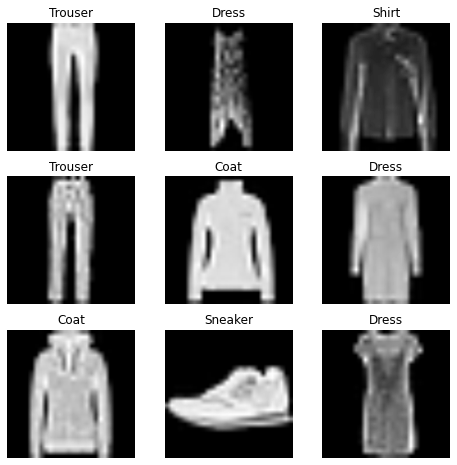

In [19]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [20]:
training_data[0][0].shape, training_data[0][1]

(torch.Size([1, 139, 139]), 9)

In [21]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
class Model(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(Model, self).__init__()

        # Load a pretrained resnet model from torchvision.models in Pytorch
        self.model = timm.create_model('inception_resnet_v2', pretrained=False)

        # Change the input layer to take Grayscale image, instead of RGB images. 
        # Hence in_channels is set as 1 or 3 respectively
        # original definition of the first layer 
        # self.conv1 = Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.model.conv2d_1a.conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, bias=False)
    
        # Change the output layer to output 10 classes instead of 1000 classes
        num_ftrs = self.model.classif.in_features
        self.model.classif = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [47]:
timm.create_model('inception_resnet_v2', pretrained=False).conv2d_1a

BasicConv2d(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)

In [24]:
model = Model()
model = model.to(device)

In [ ]:
model.model

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [26]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()

    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [27]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    return correct, test_loss
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [28]:
epochs = 20
train_acc = []
train_losses = []
test_acc = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    
    train_correct, train_loss = test(train_dataloader, model, loss_fn)
    train_acc.append(train_correct)
    train_losses.append(train_loss)
    print(f"Train Error: \n Accuracy: {(100*train_correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    test_correct, test_loss = test(train_dataloader, model, loss_fn)
    test_acc.append(test_correct)
    test_losses.append()
    print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    torch.save(model.state_dict(), f"results/model{t}.pth")
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 157/157 [00:30<00:00,  5.17it/s]


Test Error: 
 Accuracy: 78.3%, Avg loss: 0.654140 

Epoch 2
-------------------------------


 47%|████▋     | 437/938 [04:52<05:35,  1.49it/s]


KeyboardInterrupt: 